In [ ]:
from mvlearn.datasets import load_UCImultifeature
import pandas as pd
import numpy as np
from matplotlib import pyplot


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

from alignment import (
    TrivialAlignment, Affine, Procrustes, CCA, CCAv2,
    ManifoldLinear, manifold_nonlinear)
from correspondence import Correspondence
from distance import SquaredL2, L1, SparseL2
from neighborhood import neighbor_graph, laplacian
from synthetic_data import swiss_roll, add_noise, spiral, cylinder
from util import pairwise_error, Timer
from viz import show_alignment

import sklearn

from stiefel import *

import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_default_tensor_type('torch.DoubleTensor')
torch.manual_seed(1)

In [27]:
X = np.loadtxt('../../dyngen_manuscript/X.csv', delimiter=',', skiprows=1, usecols=range(1,6)).T
Y = np.loadtxt('../../dyngen_manuscript/Y.csv', delimiter=',', skiprows=1, usecols=range(1,6)).T

In [59]:
"""Defines the neural network"""

class Net(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H1)
        self.linear2 = torch.nn.Linear(H1, H2)
        self.linear3 = torch.nn.Linear(H2, D_out)

    def forward(self, x):
        h1_sigmoid = self.linear1(x).sigmoid()
        h2_sigmoid = self.linear2(h1_sigmoid).sigmoid()
        y_pred = self.linear3(h2_sigmoid)
        return y_pred

In [60]:
# data, labels = load_UCImultifeature()
# m_data = data[:2]

In [5]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
N1, N2, D_in, H1, H2, D_out = m_data[0].shape[1], m_data[1].shape[1], m_data[0].shape[0], 500, 100, 2

# Construct our model by instantiating the class defined above.
model = Net(D_in, H1, H2, D_out)

In [28]:
# Create random Tensors to hold the 2 inputs
# x1 = torch.from_numpy(m_data[0]).T
# x2 = torch.from_numpy(m_data[1]).T

# x1_np = x1.numpy()
# x2_np = x2.numpy()

x1_np = X
x2_np = Y

adj1 = neighbor_graph(x1_np, k=50)
adj2 = neighbor_graph(x2_np, k=50)

# corr = Correspondence(matrix=np.ones((76, 216)))
corr = Correspondence(matrix=np.eye(5))

w = np.block([[corr.matrix(),adj1],
              [adj2, corr.matrix().T]])

L_np = laplacian(w, normed=True)
L = torch.from_numpy(L_np)

In [51]:
X.shape

(150, 5)

In [16]:
# Construct an Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.000001)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

# loss = 10
# while loss > 5:
for t in range(10):
    # Forward pass: Compute predicted y by passing x to the model
    y1_pred = model(x1)
    y2_pred = model(x2)
    
    outputs = torch.cat((y1_pred, y2_pred), 0)
    
    # Project the output onto Stiefel Manifold
    u, s, v = torch.svd(outputs, some=True)
    proj_outputs = u@v.t()
    
    # Compute and print loss
    loss = torch.trace(proj_outputs.t()@L@proj_outputs)
    print(t, loss.item())

    # Zero gradients, perform a backward pass, and update the weights.
    proj_outputs.retain_grad()
    
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    
    # Project the (Euclidean) gradient onto the tangent space of Stiefel Manifold (to get Rimannian gradient)
    rgrad = proj_stiefel(proj_outputs, proj_outputs.grad) 
    
    optimizer.zero_grad()
    # Backpropogate the Rimannian gradient w.r.t proj_outputs
    proj_outputs.backward(rgrad)
    
    optimizer.step()

0 0.9380916561650837
1 0.9378541441537782
2 0.937611307227646
3 0.9373628484559391
4 0.937111757128064
5 0.9368650240291232
6 0.9366308611667606
7 0.9364139738481956
8 0.9362140372067825
9 0.936027984438808


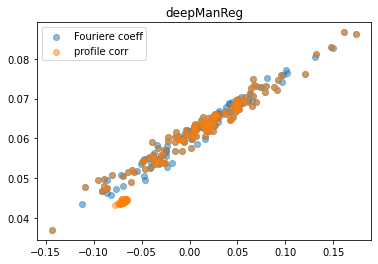

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from viz import show_alignment

show_alignment(proj_outputs.detach().numpy()[76:], proj_outputs.detach().numpy()[:216],
              titX='Fouriere coeff',titY='profile corr',title='deepManReg')
plt.savefig("scatter_deepmanreg.svg")

In [19]:
print(' sum sq. error =', pairwise_error(proj_outputs.detach().numpy()[76:], proj_outputs.detach().numpy()[:216], metric=SquaredL2))

 sum sq. error = 56.853245310483366


In [43]:
# X = m_data[0].T
# Y = m_data[1].T

Wx = neighbor_graph(X, k=50)
Wy = neighbor_graph(Y, k=50)

d = 2

linear manifold aln : 0.139 seconds
 sum sq. error = 6.967728163797501e-28


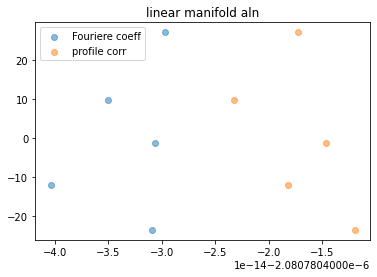

In [225]:
  lin_aligners = (
#     ('cca',              lambda: CCA(X,Y,corr,d)),
    ('linear manifold aln',  lambda: ManifoldLinear(X,Y,corr,d,Wx,Wy)),
  )

  latent = []

  other_aligners = (
#     ('dtw', lambda: (X, dtw(X,Y).warp(X))),
#     ('nonlinear manifold aln',
#      lambda: manifold_nonlinear(X,Y,corr,d,Wx,Wy)),
#     ('nonlinear manifold warp',
#      lambda: manifold_warping_nonlinear(X,Y,d,Wx,Wy)[1:]),
  )

  for name, aln in lin_aligners:
    pyplot.figure()
    with Timer(name):
      Xnew,Ynew = aln().project(X, Y)
    print(' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew,Ynew,titX='Fouriere coeff',titY='profile corr',title=name)
    plt.savefig("scatter_cca_.svg")
    latent.append(np.concatenate((Xnew, Ynew)))
    
  for name, aln in other_aligners:
    pyplot.figure()
    with Timer(name):
      Xnew,Ynew = aln()
    print (' sum sq. error =', pairwise_error(Xnew, Ynew, metric=SquaredL2))
    show_alignment(Xnew, Ynew, '')

  pyplot.show()

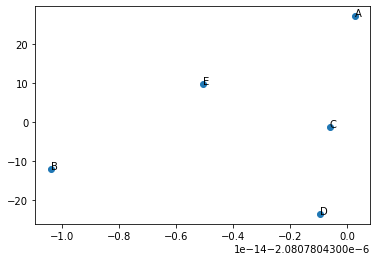

In [98]:
n = ['A','B','C','D','E']

fig, ax = pyplot.subplots()
# fig = pyplot.figure()
# ax = fig.add_subplot(projection='3d')
ax.scatter(Xnew.T[0], Xnew.T[1])

for i, txt in enumerate(n):
    ax.annotate(txt, (Xnew.T[0][i], Xnew.T[1][i]))

In [52]:
%config InlineBackend.figure_format = 'png'
import matplotlib.pyplot as plt
from pymatcher import matcher

data = [x1_np,x2_np]

m = matcher.MATCHER(data)
m.infer()

latent_matcher = [[i[0] for i in m.model[0].latent_space.mean.tolist()] +
           [i[0] for i in m.model[1].latent_space.mean.tolist()],
          [i[0] for i in m.master_time[0].tolist()] +
           [i[0] for i in m.master_time[1].tolist()]]

np.savetxt("matcher_latent.csv",np.array(latent_matcher).T,delimiter=",")

In [14]:
# matcher_latent = pd.read_csv("matcher_latent.csv", header=None).to_numpy()

In [15]:
cca_latent = latent[0]
ma_latent = latent[1]

np.savetxt("cca_latent1.csv",cca_latent,delimiter=",")
np.savetxt("ma_latent1.csv",ma_latent,delimiter=",")

In [16]:
# # D_in is input dimension;
# # H is hidden dimension; D_out is output dimension.
# N1, N2, D_in, H1, H2, D_out = m_data[0].shape[1], m_data[1].shape[1], m_data[0].shape[0], 500, 100, 10

# # Construct our model by instantiating the class defined above.
# model = Net(D_in, H1, H2, D_out)

# # Construct an Optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr = 0.000001)
# # optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

# # loss = 10
# # while loss > 5:
# for t in range(100):
#     # Forward pass: Compute predicted y by passing x to the model
#     y1_pred = model(x1)
#     y2_pred = model(x2)
    
#     outputs = torch.cat((y1_pred, y2_pred), 0)
    
#     # Project the output onto Stiefel Manifold
#     u, s, v = torch.svd(outputs, some=True)
#     proj_outputs = u@v.t()
    
#     # Compute and print loss
#     loss = torch.trace(proj_outputs.t()@L@proj_outputs)
#     print(t, loss.item())

#     # Zero gradients, perform a backward pass, and update the weights.
#     proj_outputs.retain_grad()
    
#     optimizer.zero_grad()
#     loss.backward(retain_graph=True)
    
#     # Project the (Euclidean) gradient onto the tangent space of Stiefel Manifold (to get Rimannian gradient)
#     rgrad = proj_stiefel(proj_outputs, proj_outputs.grad) 
    
#     optimizer.zero_grad()
#     # Backpropogate the Rimannian gradient w.r.t proj_outputs
#     proj_outputs.backward(rgrad)
    

In [17]:
np.savetxt("deep_latent.csv",proj_outputs.detach().numpy(),delimiter=",")

In [16]:
# proj_outputs.detach().numpy().shape

In [53]:
from numpy import genfromtxt
my_data = genfromtxt('matcher_latent.csv', delimiter=',')

In [58]:
my_data.shape

(10, 2)

In [ ]:
import matplotlib.pyplot as plt

show_alignment(my_data[5:], my_data[:5],
              titX='Fouriere coeff',titY='profile corr',title='MATCHER')
plt.savefig("scatter_MATCHer.svg")

print(' sum sq. error =', pairwise_error(my_data[76:], my_data[:216], metric=SquaredL2))

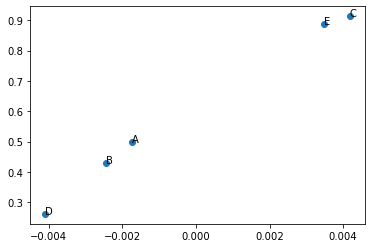

In [67]:
n = ['A','B','C','D','E']

fig, ax = pyplot.subplots()
# fig = pyplot.figure()
# ax = fig.add_subplot(projection='3d')
ax.scatter(my_data[:5].T[0], my_data[:5].T[1])

for i, txt in enumerate(n):
    ax.annotate(txt, (my_data[:5].T[0][i], my_data[:5].T[1][i]))

In [68]:
O = np.matrix('0 0 1 1 0; 0 0 0 1 1; 1 0 0 0 1; 1 1 0 0 0; 0 1 1 0 0') 

In [69]:
O

matrix([[0, 0, 1, 1, 0],
        [0, 0, 0, 1, 1],
        [1, 0, 0, 0, 1],
        [1, 1, 0, 0, 0],
        [0, 1, 1, 0, 0]])

In [226]:
Xnew_dist = sklearn.metrics.pairwise_distances(Xnew)
Ynew_dist = sklearn.metrics.pairwise_distances(Ynew)

# Xnew_dist = (abs(Xnew_dist) - np.min(abs(Xnew_dist)))/np.ptp(abs(Xnew_dist))
# Ynew_dist = (abs(Ynew_dist) - np.min(abs(Ynew_dist)))/np.ptp(abs(Ynew_dist))

Xnew_dist = neighbor_graph(Xnew_dist, k=2)
Ynew_dist = neighbor_graph(Ynew_dist, k=2)

In [188]:
1-O

matrix([[1, 1, 0, 0, 1],
        [1, 1, 1, 0, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 1, 1],
        [1, 0, 0, 1, 1]])

In [216]:
Xnew_dist - Ynew_dist

array([[ 0., -1.,  0.,  0., -1.],
       [-1.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  1.,  0.,  1.],
       [-1.,  1.,  0.,  1.,  0.]])

In [227]:
lma_dist = abs(Xnew_dist - O) + abs(Ynew_dist - O) + abs(Xnew_dist - Ynew_dist)
# dmr_dist = np.corrcoef((Xnew_dist + Ynew_dist)/2, O)# + np.corrcoef(Ynew_dist, O)

In [229]:
lma_dist.sum()

20.0

In [224]:
cca_dist.sum()

24.0

In [218]:
dmr_dist.sum()

16.0

In [217]:
matcher_dist.sum()

20.0

In [99]:
lma_sig = np.array([44.48248988, 66.75598775])

In [117]:
lma_dist[np.tril_indices(5)]

matrix([[ 0.        , 78.33304401,  0.        , 54.91180539, 21.42123861,
          0.        , 99.39429527, 21.06125127, 44.48248988,  0.        ,
         34.63830752, 41.69473648, 20.27349787, 66.75598775,  0.        ]])

In [118]:
lma_nonsig = np.array([78.33304401, 54.91180539, 21.42123861,
          99.39429527, 21.06125127, 44.48248988,  
         34.63830752, 41.69473648, 20.27349787, 66.75598775])

{'whiskers': [<matplotlib.lines.Line2D at 0x15a5aebe0>,
 'caps': [<matplotlib.lines.Line2D at 0x15a593340>,
 'boxes': [<matplotlib.lines.Line2D at 0x15a5ae850>,
 'medians': [<matplotlib.lines.Line2D at 0x15a593a60>,
 'fliers': [<matplotlib.lines.Line2D at 0x15a593df0>,
 'means': []}

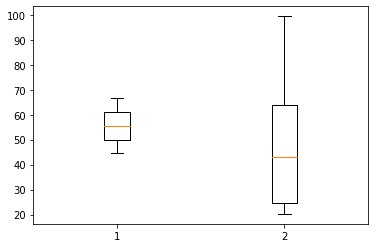

In [126]:
fig, ax = pyplot.subplots()

ax.boxplot([lma_sig, lma_nonsig])

In [127]:
dmr_sig = np.array([1.25945676, 1.07151924])

In [128]:
dmr_dist[np.tril_indices(5)]

matrix([[0.        , 1.25945676, 0.        , 1.34083307, 1.66148935,
         0.        , 0.38319128, 0.21636522, 2.26577011, 0.        ,
         0.707985  , 1.09399043, 0.65117326, 1.07151924, 0.        ]])

In [129]:
dmr_nonsig = np.array([1.25945676      , 1.34083307, 1.66148935,
         0.38319128, 0.21636522, 2.26577011, 
         0.707985  , 1.09399043, 0.65117326, 1.07151924])

<Figure size 432x288 with 0 Axes>

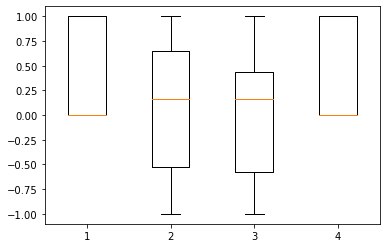

In [215]:
pyplot.tight_layout(pad=10)
fig, ax = pyplot.subplots()

ax.boxplot([np.ravel(dmr_dist/2), np.ravel(cca_dist/2), np.ravel(lma_dist/2), np.ravel(matcher_dist/2)])

# pyplot.savefig('box.svg')

In [133]:
np.ravel(dmr_dist)

array([0.        , 1.25945676, 1.34083307, 0.38319128, 0.707985  ,
       1.25945676, 0.        , 1.66148935, 0.21636522, 1.09399043,
       1.34083307, 1.66148935, 0.        , 2.26577011, 0.65117326,
       0.38319128, 0.21636522, 2.26577011, 0.        , 1.07151924,
       0.707985  , 1.09399043, 0.65117326, 1.07151924, 0.        ])

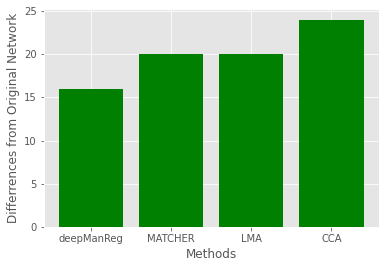

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

x = ['deepManReg', 'MATCHER', 'LMA', 'CCA']
energy = [16, 20, 20, 24]

x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, energy, color='green')
plt.xlabel("Methods")
plt.ylabel("Differrences from Original Network")
plt.title("")

plt.xticks(x_pos, x)
plt.savefig("simulated.eps")
plt.show()
